### Check extracted keywords

### Feature table extraction : Training data for model

In [41]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import textstat
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
import re
from rake_nltk import Rake  # RAKE library for keyword extraction

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load dataset
file_path = "dataset final/testing.xlsx"
data = pd.read_excel(file_path)

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Stop words
stop_words = set(stopwords.words('english'))

# RAKE initialization
rake = Rake(stopwords=stop_words)

# Helper functions
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed = [stemmer.stem(word) for word in lemmatized]
    return stemmed

def extract_qtype(question):
    rake.extract_keywords_from_text(question)
    keywords = rake.get_ranked_phrases()
    computational_keywords = {"perform", "generate", "database", "create", "design", "implement", "calculate", "determine", "solve", "compute", "evaluate", "simplify"}
    descriptive_keywords = {"justify", "method", "process", "procedure", "solution", "explain", "describe", "illustrate", "state", "discuss", "write", "why"}
    proof_keywords = {"prove", "verify", "demonstrate", "show"}
    statistical_keywords = {"test", "hypothesis", "mean", "variance", "confidence", "significance"}
    what_keywords = {"what", "define", "list"}
    differentiate_keywords = {"differentiate", "contrast", "compare"}
    mathematical_keywords = {"solve", "convert", "find", "equation", "function", "integral", "derivative", "matrix"}
    discrete_keywords = {"graph", "logic", "combinatorics", "relation", "algorithm"}
    
    scores = {"Computational": 0, "Descriptive": 0, "Proof": 0, "Statistical": 0, "What": 0, "Differentiate": 0, "Mathematical": 0, "Discrete": 0, "Other": 0}

    for phrase in keywords:
        words = phrase.split()
        for word in words:
            if word in computational_keywords:
                scores["Computational"] += 1
            elif word in descriptive_keywords:
                scores["Descriptive"] += 1
            elif word in proof_keywords:
                scores["Proof"] += 1
            elif word in statistical_keywords:
                scores["Statistical"] += 1
            elif word in what_keywords:
                scores["What"] += 1
            elif word in differentiate_keywords:
                scores["Differentiate"] += 1
            elif word in mathematical_keywords:
                scores["Mathematical"] += 1
            elif word in discrete_keywords:
                scores["Discrete"] += 1

    max_score_type = max(scores, key=scores.get)
    return "Other" if scores[max_score_type] == 0 else max_score_type

def keyword_count(question):
    rake.extract_keywords_from_text(question)
    keywords = rake.get_ranked_phrases()
    return len(keywords)

def compute_tf_idf(questions):
    tf = []
    idf = {}
    N = len(questions)
    vocabulary = set()
    processed_questions = [preprocess_text(q) for q in questions]
    for q in processed_questions:
        freq = {}
        for word in q:
            vocabulary.add(word)
            freq[word] = freq.get(word, 0) + 1
        tf.append(freq)

    for word in vocabulary:
        count = sum(1 for q in processed_questions if word in q)
        idf[word] = np.log(N / (1 + count))

    tf_idf_scores = []
    for q_tf in tf:
        scores = {word: tf_val * idf[word] for word, tf_val in q_tf.items()}
        tf_idf_scores.append(scores)
    return tf_idf_scores

def avg_word_length(text):
    question_tokens = preprocess_text(text)
    total_length = sum(len(word) for word in question_tokens)
    return 0 if not question_tokens else total_length / len(question_tokens)

def sentence_count(question):
    return len(re.split(r'[.!?]', question)) - 1

def readability_score(question):
    sentences = sent_tokenize(question)
    words = word_tokenize(question)
    complex_words = [word for word in words if len(word) > 2 and word not in string.punctuation]
    word_count = len(words)
    sentence_count = len(sentences)
    complex_word_count = len(complex_words)
    
    if sentence_count == 0 or word_count == 0:
        return 0
    gunning_fog = 0.4 * ((word_count / sentence_count) + 100 * (complex_word_count / word_count))
    return gunning_fog

# Extract features
data["qtype"] = data["questions"].apply(extract_qtype)
data["keyword_count"] = data["questions"].apply(keyword_count)
tf_idf_scores = compute_tf_idf(data["questions"].fillna(""))
data["keyword_tfidf"] = [np.mean(list(scores.values())) if scores else 0 for scores in tf_idf_scores]
data["sentence_count"] = data["questions"].apply(sentence_count)
data["readability_scores"] = data["questions"].apply(readability_score)
data["avg_word_length"] = data["questions"].apply(avg_word_length)

# One-hot encoding for qtype
encoder = OneHotEncoder(sparse_output=False)
qtype_encoded = encoder.fit_transform(data[["qtype"]])
qtype_encoded_df = pd.DataFrame(qtype_encoded, columns=encoder.get_feature_names_out(["qtype"]))
data = pd.concat([data.reset_index(drop=True), qtype_encoded_df.reset_index(drop=True)], axis=1)

# Encode target value
difficulty_mapping = {"easy": 0, "moderate": 1, "hard": 2}
data["difficulty_level_encoded"] = data["difficulty_level"].map(difficulty_mapping)

# Save training dataset
feature_columns = qtype_encoded_df.columns.tolist() + ["keyword_count", "keyword_tfidf", "sentence_count", "readability_scores", "avg_word_length"]
training_dataset = data[feature_columns + ["difficulty_level_encoded"]]
output_file = "dataset final/training_dataset.csv"
training_dataset.to_csv(output_file, index=False)

print(f"Training dataset with one-hot encoding saved to {output_file}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training dataset with one-hot encoding saved to dataset final/training_dataset.csv


### Data Preprocessing before passing for training model

#### Step 1: Load the Dataset Step 2: Inspect the Dataset

In [42]:
import pandas as pd

# Load your dataset (replace with the actual file name and format)
df = pd.read_csv('dataset final/training_dataset.csv')  # Use pd.read_excel() if the file is Excel

# Check the first few rows
print(df.head())

# Inspect df types and null counts
print(df.info())

# Check for statistical summary
print(df.describe())


   qtype_Computational  qtype_Descriptive  qtype_Differentiate  \
0                  0.0                1.0                  0.0   
1                  0.0                1.0                  0.0   
2                  1.0                0.0                  0.0   
3                  0.0                0.0                  1.0   
4                  0.0                0.0                  1.0   

   qtype_Discrete  qtype_Mathematical  qtype_Other  qtype_Proof  \
0             0.0                 0.0          0.0          0.0   
1             0.0                 0.0          0.0          0.0   
2             0.0                 0.0          0.0          0.0   
3             0.0                 0.0          0.0          0.0   
4             0.0                 0.0          0.0          0.0   

   qtype_Statistical  qtype_What  keyword_count  keyword_tfidf  \
0                0.0         0.0              6       4.322108   
1                0.0         0.0              6       4.526109   
2 

#### Step 3: Handle Missing Values

In [43]:
# Check for missing values
print(df.isnull().sum())

qtype_Computational         0
qtype_Descriptive           0
qtype_Differentiate         0
qtype_Discrete              0
qtype_Mathematical          0
qtype_Other                 0
qtype_Proof                 0
qtype_Statistical           0
qtype_What                  0
keyword_count               0
keyword_tfidf               0
sentence_count              0
readability_scores          0
avg_word_length             0
difficulty_level_encoded    0
dtype: int64


In [44]:
# Check for missing values
#print(df.isnull().sum())

# Drop rows with missing target values
df = df.dropna(subset=['difficulty_level_encoded'])

# Fill missing values in other features (example: using the mean)
df = df.fillna(df.mean())
print(df.isnull().sum())
df.info()
df.head()


qtype_Computational         0
qtype_Descriptive           0
qtype_Differentiate         0
qtype_Discrete              0
qtype_Mathematical          0
qtype_Other                 0
qtype_Proof                 0
qtype_Statistical           0
qtype_What                  0
keyword_count               0
keyword_tfidf               0
sentence_count              0
readability_scores          0
avg_word_length             0
difficulty_level_encoded    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   qtype_Computational       1199 non-null   float64
 1   qtype_Descriptive         1199 non-null   float64
 2   qtype_Differentiate       1199 non-null   float64
 3   qtype_Discrete            1199 non-null   float64
 4   qtype_Mathematical        1199 non-null   float64
 5   qtype_Other               1199 non-null 

,qtype_Computational,qtype_Descriptive,qtype_Differentiate,qtype_Discrete,qtype_Mathematical,qtype_Other,qtype_Proof,qtype_Statistical,qtype_What,keyword_count,keyword_tfidf,sentence_count,readability_scores,avg_word_length,difficulty_level_encoded
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4.322108,3,32.666667,6.428571,2
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4.526109,3,30.892754,6.083333,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3.885067,3,29.466667,6.700000,2
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4.780080,2,32.333333,7.125000,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7.979662,2,32.400000,6.714286,1


In [ ]:
df.to_csv('training data/preprocessed_trainingdataset.csv', index=False)

print("Pre-processed data saved to preprocessed_trainingdataset.csv")

### built in decsion tree trial

In [46]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['difficulty_level_encoded'])  # Features
y = df['difficulty_level_encoded']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (959, 14)
Testing set size: (240, 14)


In [34]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

print("Decision Tree model trained successfully.")


Decision Tree model trained successfully.


In [35]:
# Predict on the test set
y_pred = dt_model.predict(X_test)

In [36]:
import json
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

with open('classification_report.json', 'w') as json_file:
    json.dump(classification_report(y_test, y_pred), json_file, indent=4)


Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        49
           1       0.71      0.68      0.70        47
           2       0.57      0.57      0.57        44

    accuracy                           0.65       140
   macro avg       0.65      0.65      0.65       140
weighted avg       0.65      0.65      0.65       140



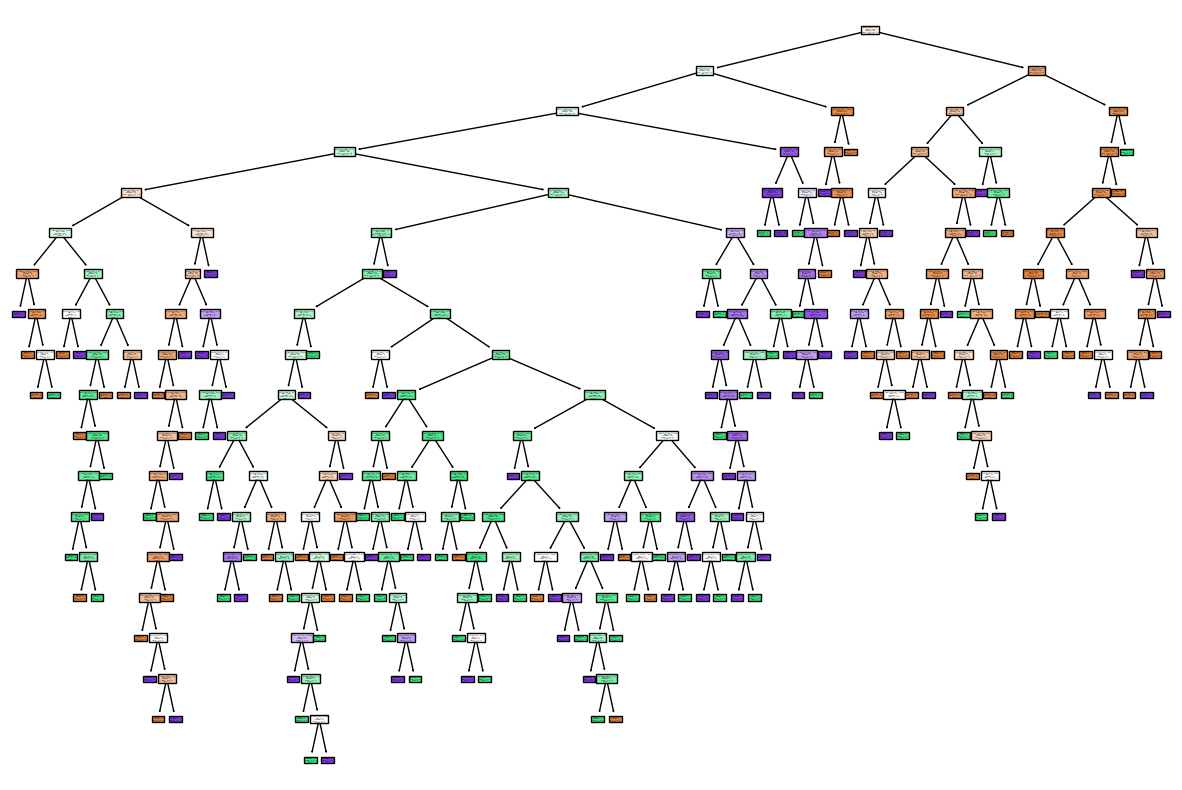

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert feature names to a list
feature_names = X.columns.tolist()

# Convert class labels (y) to a list of strings (optional but recommended for clarity)
class_names = [str(label) for label in y.unique()]

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict and evaluate
y_pred = dt_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[30 26 12]
 [44 46 27]
 [ 7 14 34]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.37      0.44      0.40        68
         1.0       0.53      0.39      0.45       117
         2.0       0.47      0.62      0.53        55

    accuracy                           0.46       240
   macro avg       0.46      0.48      0.46       240
weighted avg       0.47      0.46      0.46       240



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy with Tuned Model:", accuracy)


Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test Set Accuracy with Tuned Model: 0.5375


In [15]:
print("Sample Data:", df[:5])  # Display a few rows
for row in df:
    assert isinstance(row, list), "Each row must be a list"
    assert isinstance(row[-1], (int, float)), "Target values must be numeric"

Sample Data:    qtype_Computational  qtype_Descriptive  qtype_Differentiate  \
0                  0.0                1.0                  0.0   
1                  0.0                1.0                  0.0   
2                  1.0                0.0                  0.0   
3                  0.0                0.0                  1.0   
4                  0.0                0.0                  1.0   

   qtype_Discrete  qtype_Mathematical  qtype_Other  qtype_Proof  \
0             0.0                 0.0          0.0          0.0   
1             0.0                 0.0          0.0          0.0   
2             0.0                 0.0          0.0          0.0   
3             0.0                 0.0          0.0          0.0   
4             0.0                 0.0          0.0          0.0   

   qtype_Statistical  qtype_What  keyword_count  keyword_tfidf  \
0                0.0         0.0              6       4.322108   
1                0.0         0.0              6       4

AssertionError: Each row must be a list